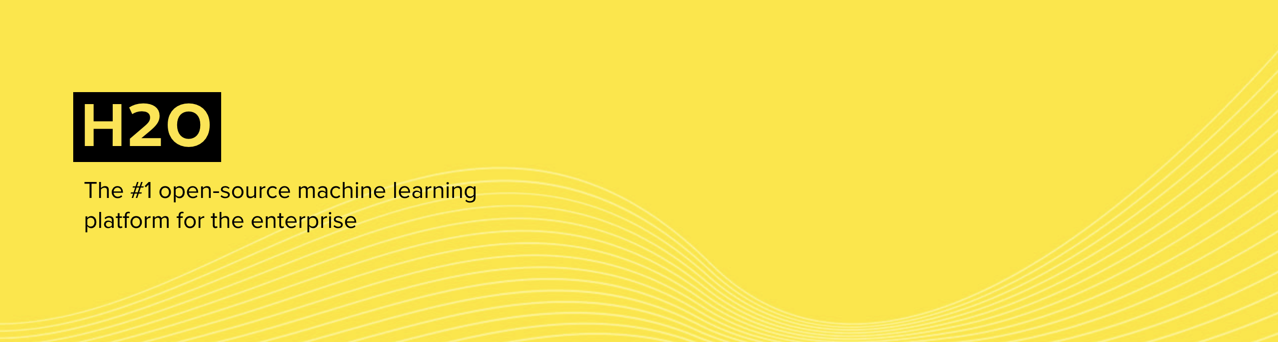

## License 

<span style="color:gray"> Copyright 2022 David Whiting and Greg Keys

<span style="color:gray"> Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

<span style="color:gray">     http://www.apache.org/licenses/LICENSE-2.0

<span style="color:gray"> Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<span style="color:gray"> **DISCLAIMER:** This notebook is not legal compliance advice. </span>

<hr style="background-color: gray;height: 2.0px;"/>

# Chapter 7 - Lending Club

## Start the H2O-3 cluster

We start the cluster assuming it is locally installed. Your startup commands will depend on your setup. _See Appendix A for details._

Your numeric results may vary somewhat from that shown in the text if the H2O cluster version or the number of nodes and cores available to the H2O server are different from what was used in the book.

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "14.0.2" 2020-07-14; Java(TM) SE Runtime Environment (build 14.0.2+12-46); Java HotSpot(TM) 64-Bit Server VM (build 14.0.2+12-46, mixed mode, sharing)
  Starting server from /Users/david/local/miniconda3/envs/packt/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmpq9b7xl_q
  JVM stdout: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmpq9b7xl_q/h2o_david_started_from_python.out
  JVM stderr: /var/folders/vc/p3y1h0bs6tv7n439qrgmq9980000gq/T/tmpq9b7xl_q/h2o_david_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_david_d8aywj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


## Recreate the gbm model from Chapter 5.

In [2]:
#input_csv = "https://github.com/PacktPublishing/Machine-Learning-at-Scale-with-H2O/chapt7/loans.csv"
input_csv = "https://s3.amazonaws.com/data.h2o.ai/Machine-Learning-at-Scale/lending_club/loans.csv"

loans = h2o.import_file(input_csv)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [3]:
loans["bad_loan"] = loans["bad_loan"].asfactor()
loans["issue_d_year"] = loans["issue_d"].year().asfactor()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

train, valid, test = loans.split_frame(
    seed = 25,
    ratios = [0.6, 0.2],
    destination_frames = ["train", "valid", "test"])

train_cv, test_cv = loans.split_frame(
    seed = 25,                        
    ratios = [0.8],                                      
    destination_frames = ["train_cv", "test_cv"])

response = "bad_loan"
omit = ["issue_d", response]
predictors = list(set(loans.columns) - set(omit))

In [4]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm = H2OGradientBoostingEstimator(seed = 25)
gbm.train(x = predictors,
          y = response,
          training_frame = train,
          validation_frame = valid,
          model_id = "gbm_baseline")

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25098.0,5.0,5.0,5.0,17.0,32.0,28.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10439619983523844
RMSE: 0.323104007767218
LogLoss: 0.3442076458354961
Mean Per-Class Error: 0.2813394331209395
AUC: 0.8264100301886944
AUCPR: 0.557378730541788
Gini: 0.6528200603773888

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2567501506428664: 


,,0,1,Error,Rate
0,0,17703.0,2000.0,0.1015,(2000.0/19703.0)
1,1,1740.0,2033.0,0.4612,(1740.0/3773.0)
2,Total,19443.0,4033.0,0.1593,(3740.0/23476.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.256750,0.520881,185.0
1,max f2,0.146769,0.615068,270.0
2,max f0point5,0.365991,0.553303,125.0
3,max accuracy,0.402041,0.867184,110.0
4,max precision,0.962235,1.000000,0.0
5,max recall,0.030916,1.000000,388.0
6,max specificity,0.962235,1.000000,0.0
7,max absolute_mcc,0.290534,0.426969,164.0
8,max min_per_class_accuracy,0.170853,0.741055,249.0
9,max mean_per_class_accuracy,0.180535,0.742964,242.0



Gains/Lift Table: Avg response rate: 16.07 %, avg score: 16.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.611237,5.957334,5.957334,0.957447,0.687928,0.957447,0.687928,0.059634,0.059634,495.733403,495.733403,0.059127
1,2,0.020020,0.537543,5.215977,5.586655,0.838298,0.570906,0.897872,0.629417,0.052213,0.111847,421.597690,458.665546,0.109411
2,3,0.030031,0.486934,4.686436,5.286582,0.753191,0.511122,0.849645,0.589985,0.046912,0.158760,368.643610,428.658234,0.153380
3,4,0.040041,0.451636,4.474620,5.083592,0.719149,0.468713,0.817021,0.559667,0.044792,0.203552,347.461978,408.359170,0.194822
4,5,0.050009,0.424924,3.563085,4.780527,0.572650,0.437074,0.768313,0.535232,0.035516,0.239067,256.308544,378.052657,0.225262
5,6,0.100017,0.329193,2.920255,3.850391,0.469336,0.372139,0.618825,0.453685,0.146038,0.385105,192.025514,285.039086,0.339680
6,7,0.150026,0.275002,2.236566,3.312449,0.359455,0.300399,0.532368,0.402590,0.111847,0.496952,123.656565,231.244912,0.413361
7,8,0.200034,0.235718,1.695974,2.908330,0.272572,0.254101,0.467419,0.365468,0.084813,0.581765,69.597395,190.833033,0.454830
8,9,0.300009,0.184735,1.232756,2.349964,0.198125,0.208301,0.377680,0.313094,0.123244,0.705009,23.275610,134.996419,0.482556
9,10,0.400026,0.149818,0.930136,1.994969,0.149489,0.166140,0.320626,0.276352,0.093029,0.798039,-6.986429,99.496927,0.474230




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12387962121385686
RMSE: 0.3519653693388838
LogLoss: 0.4005986897473847
Mean Per-Class Error: 0.33559788779727173
AUC: 0.7204978140549837
AUCPR: 0.333202223041529
Gini: 0.4409956281099674

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1699389851405903: 


,,0,1,Error,Rate
0,0,4630.0,1911.0,0.2922,(1911.0/6541.0)
1,1,481.0,788.0,0.379,(481.0/1269.0)
2,Total,5111.0,2699.0,0.3063,(2392.0/7810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169939,0.397177,239.0
1,max f2,0.107599,0.542603,300.0
2,max f0point5,0.305263,0.375231,139.0
3,max accuracy,0.531806,0.838412,41.0
4,max precision,0.751003,0.600000,4.0
5,max recall,0.025797,1.000000,391.0
6,max specificity,0.792153,0.999847,0.0
7,max absolute_mcc,0.169939,0.255056,239.0
8,max min_per_class_accuracy,0.154076,0.660908,254.0
9,max mean_per_class_accuracy,0.163881,0.664650,245.0



Gains/Lift Table: Avg response rate: 16.25 %, avg score: 15.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010115,0.564217,3.194083,3.194083,0.518987,0.638585,0.518987,0.638585,0.032309,0.032309,219.408285,219.408285,0.026499
1,2,0.020102,0.498629,2.998323,3.096826,0.487179,0.526829,0.503185,0.583063,0.029945,0.062254,199.832293,209.682633,0.050329
2,3,0.030090,0.460240,2.998323,3.064132,0.487179,0.478505,0.497872,0.548359,0.029945,0.092199,199.832293,206.413158,0.074159
3,4,0.040077,0.433469,2.919420,3.028069,0.474359,0.446322,0.492013,0.522931,0.029157,0.121355,191.941969,202.806919,0.097047
4,5,0.050064,0.407082,2.209291,2.864732,0.358974,0.419242,0.465473,0.502246,0.022065,0.143420,120.929058,186.473228,0.111468
5,6,0.100000,0.320596,2.209291,2.537431,0.358974,0.361088,0.412292,0.431757,0.110323,0.253743,120.929058,153.743105,0.183570
6,7,0.150064,0.268848,1.936055,2.336801,0.314578,0.293761,0.379693,0.385719,0.096927,0.350670,93.605533,133.680144,0.239525
7,8,0.200000,0.235913,1.467600,2.119779,0.238462,0.252111,0.344430,0.352360,0.073286,0.423956,46.760017,111.977935,0.267405
8,9,0.300000,0.185091,1.347518,1.862359,0.218950,0.209001,0.302603,0.304574,0.134752,0.558708,34.751773,86.235881,0.308899
9,10,0.400000,0.151340,1.126872,1.678487,0.183099,0.167554,0.272727,0.270319,0.112687,0.671395,12.687155,67.848700,0.324047




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-26 22:47:34,0.021 sec,0.0,0.367270,0.440857,0.500000,0.160717,1.000000,0.839283,0.368898,0.443778,0.500000,0.162484,1.000000,0.837516
1,,2022-06-26 22:47:34,0.250 sec,1.0,0.363496,0.431073,0.724770,0.352472,3.388524,0.291532,0.365744,0.435527,0.694135,0.306118,2.657604,0.301280
2,,2022-06-26 22:47:34,0.375 sec,2.0,0.360348,0.423406,0.737858,0.376850,4.195207,0.259882,0.363261,0.429309,0.708830,0.314982,2.692573,0.235339
3,,2022-06-26 22:47:34,0.515 sec,3.0,0.357719,0.417264,0.742328,0.386323,4.297470,0.235900,0.361175,0.424292,0.711321,0.321212,2.743551,0.267222
4,,2022-06-26 22:47:34,0.673 sec,4.0,0.355329,0.411877,0.745820,0.394224,4.234488,0.233515,0.359393,0.420085,0.714864,0.327190,2.852063,0.234187
5,,2022-06-26 22:47:34,0.891 sec,5.0,0.353233,0.407225,0.748230,0.402690,4.580528,0.230874,0.358025,0.416953,0.713405,0.333391,3.208172,0.246607
6,,2022-06-26 22:47:35,1.016 sec,6.0,0.351303,0.403034,0.752153,0.411248,4.437470,0.214900,0.356726,0.413983,0.715861,0.336023,3.538810,0.284251
7,,2022-06-26 22:47:35,1.110 sec,7.0,0.349719,0.399597,0.755019,0.415760,4.569358,0.223973,0.355955,0.412134,0.716146,0.333251,3.583605,0.252881
8,,2022-06-26 22:47:35,1.222 sec,8.0,0.348257,0.396334,0.758561,0.421292,4.672825,0.217754,0.355254,0.410432,0.715719,0.334028,3.661510,0.247247
9,,2022-06-26 22:47:35,1.335 sec,9.0,0.346854,0.393172,0.762583,0.426892,4.845298,0.217839,0.354678,0.408960,0.716166,0.333977,3.427796,0.251857



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,addr_state,936.505737,1.000000,0.271917
1,term,654.834778,0.699232,0.190133
2,int_rate,575.092773,0.614084,0.166980
3,purpose,297.615906,0.317794,0.086414
4,issue_d_month,226.601074,0.241964,0.065794
5,annual_inc,218.534576,0.233351,0.063452
6,revol_util,133.061417,0.142083,0.038635
7,issue_d_year,132.091278,0.141047,0.038353
8,emp_length,61.177666,0.065325,0.017763
9,dti,51.353638,0.054835,0.014911


## Global Explanations for Single Models

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## gbm_baseline


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2027523844610062: 


,,0,1,Error,Rate
0,0,5111.0,1421.0,0.2175,(1421.0/6532.0)
1,1,589.0,573.0,0.5069,(589.0/1162.0)
2,Total,5700.0,1994.0,0.2612,(2010.0/7694.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

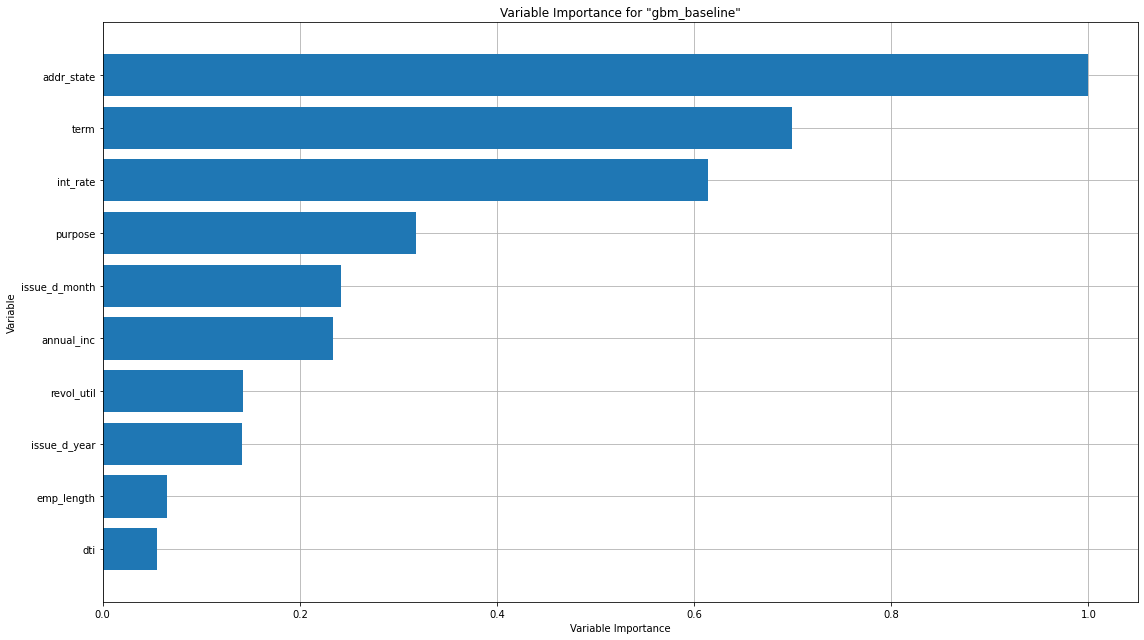

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

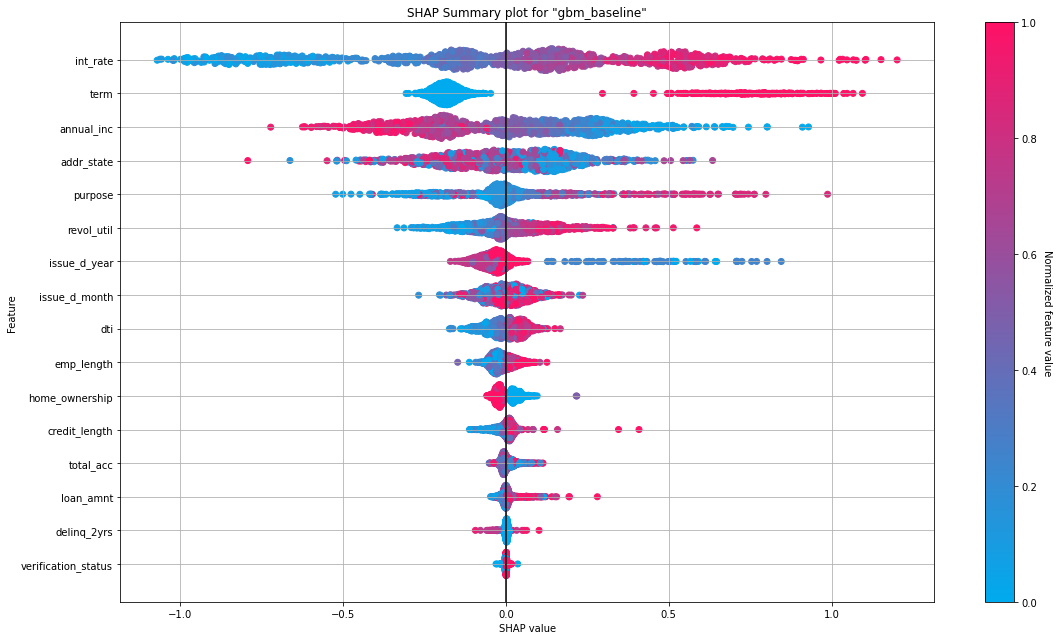

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

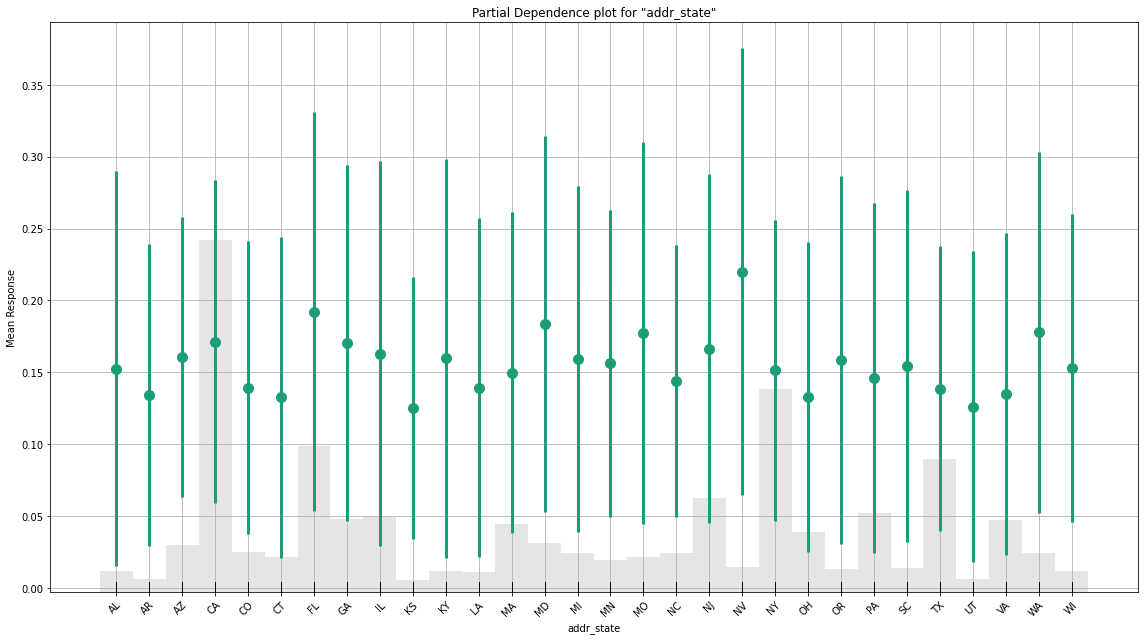

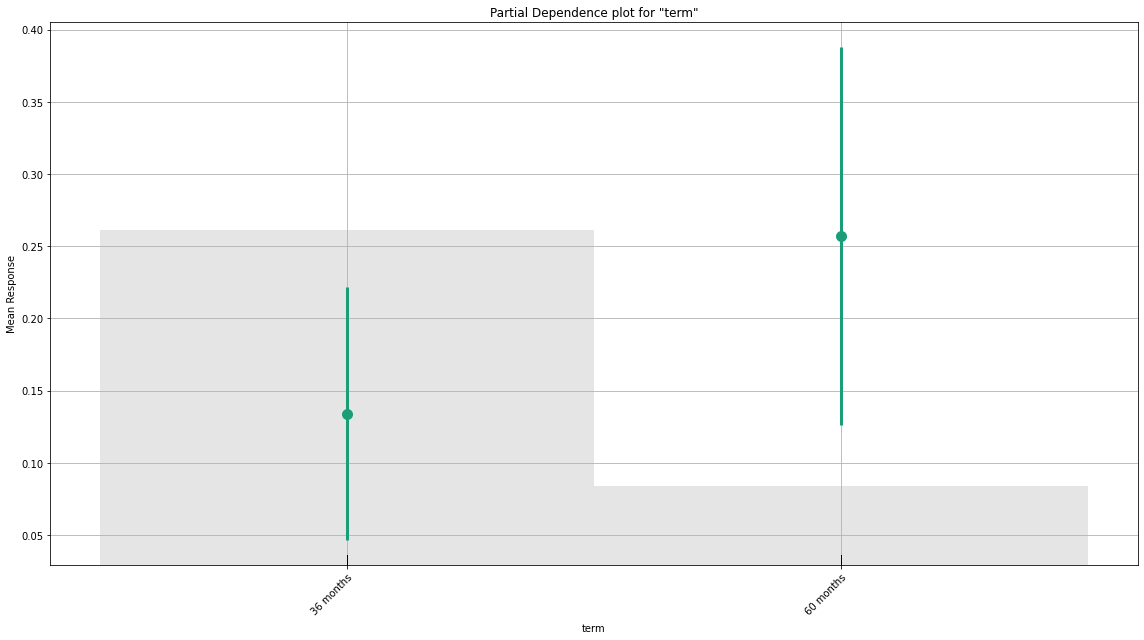

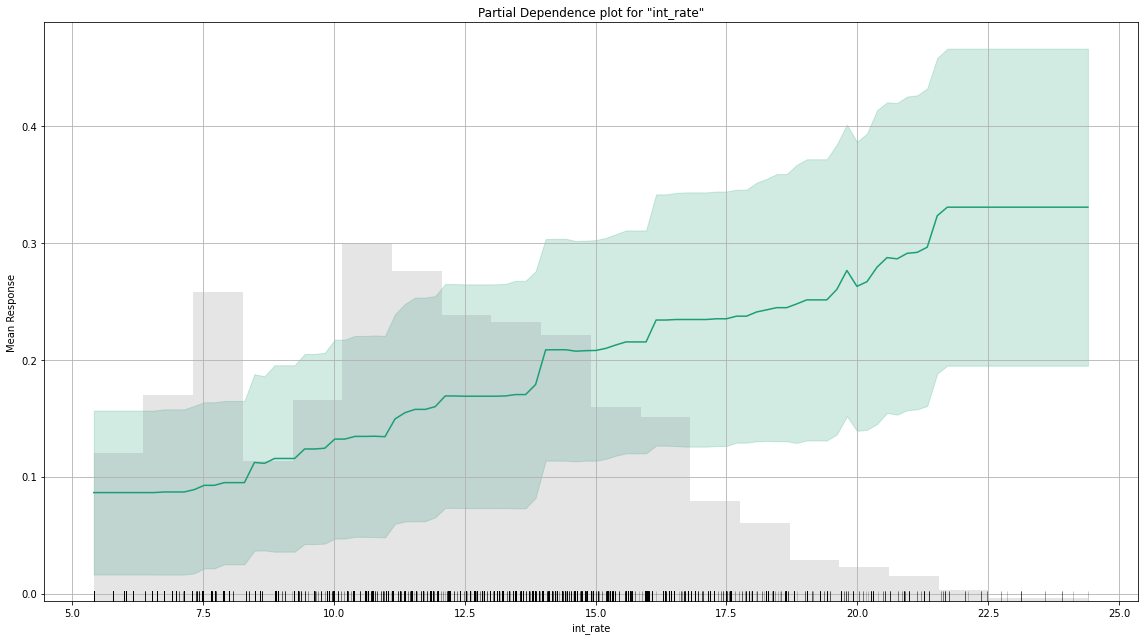

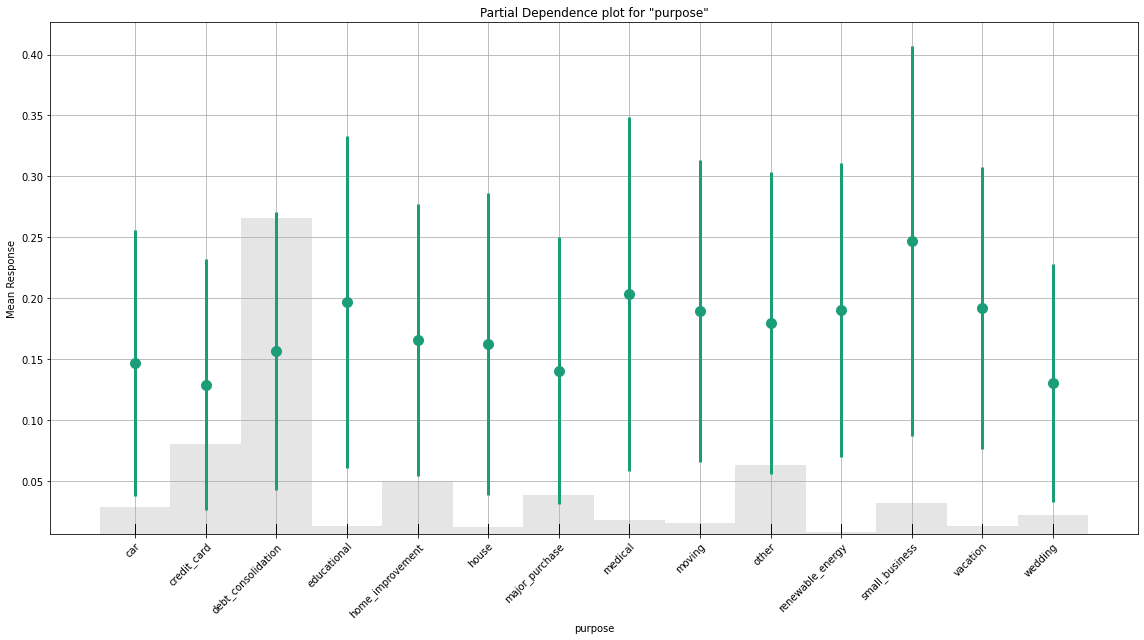

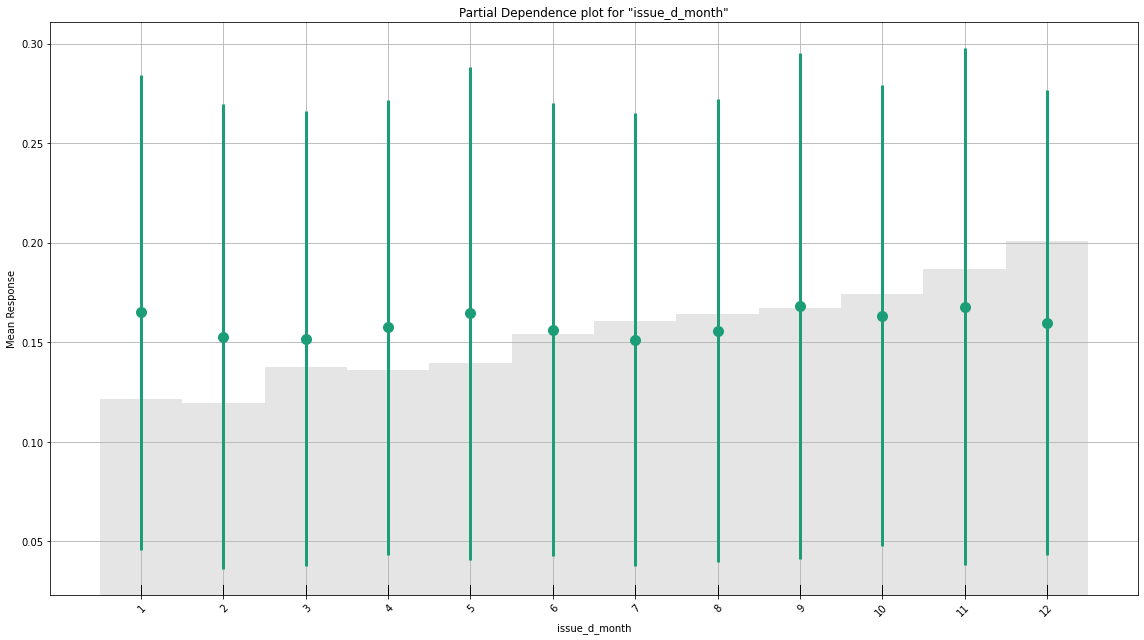

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## gbm_baseline


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2027523844610062: 


,,0,1,Error,Rate
0,0,5111.0,1421.0,0.2175,(1421.0/6532.0)
1,1,589.0,573.0,0.5069,(589.0/1162.0)
2,Total,5700.0,1994.0,0.2612,(2010.0/7694.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [5]:
%matplotlib inline
gbm.explain(test)

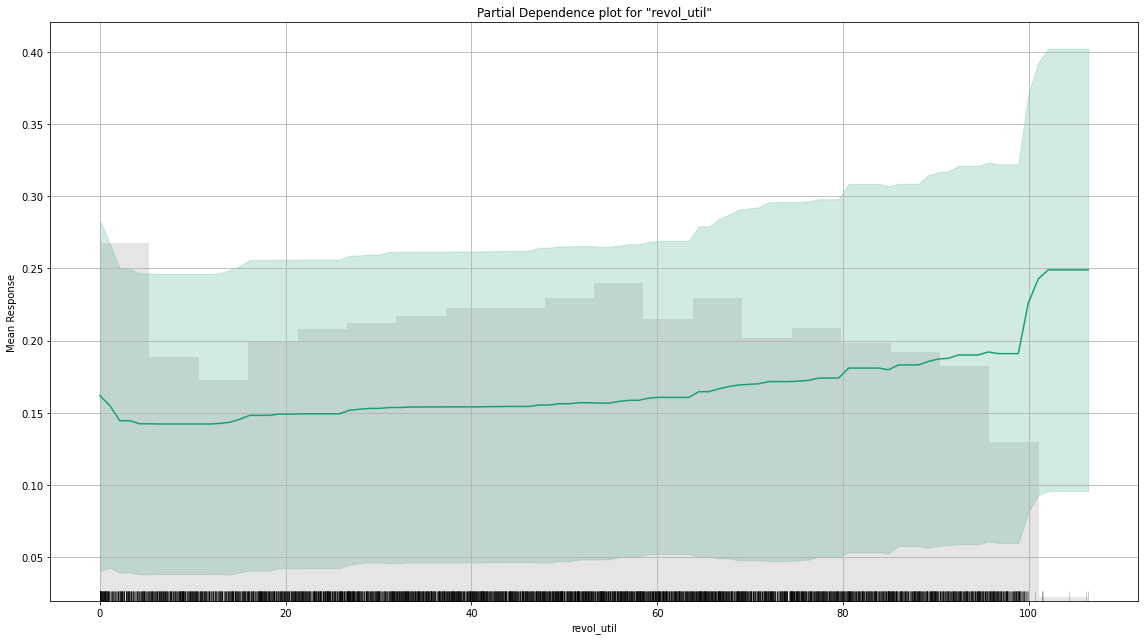

In [6]:
gbm.pd_plot(test, column="revol_util")

### The Global ICE plot

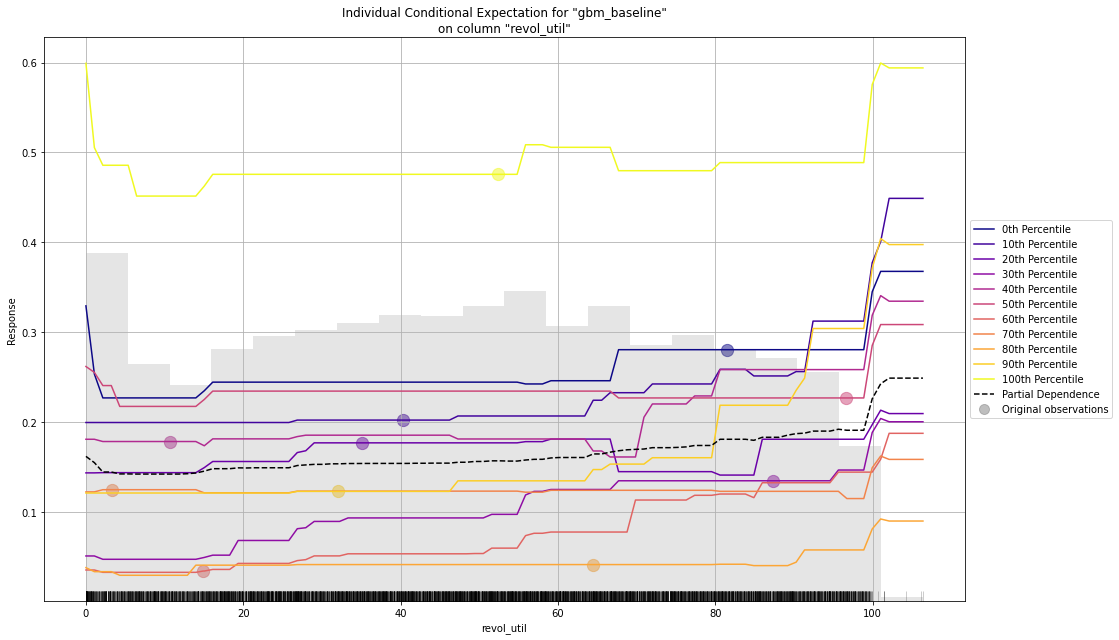

In [7]:
gbm.ice_plot(test, column="revol_util")

## Local Explanations for Single Models

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

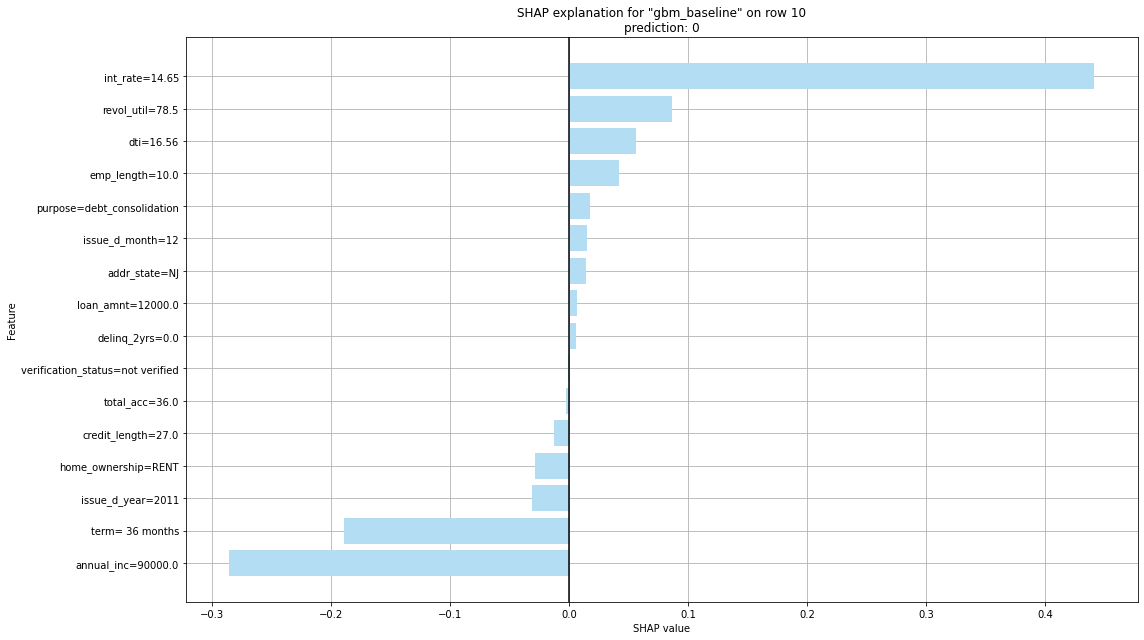

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

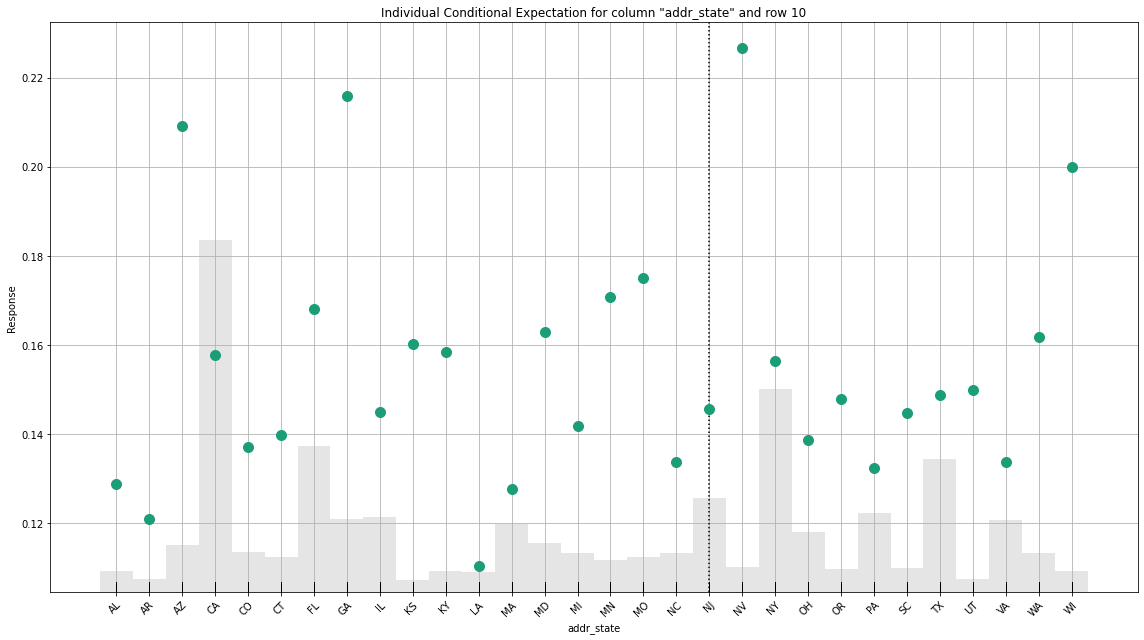

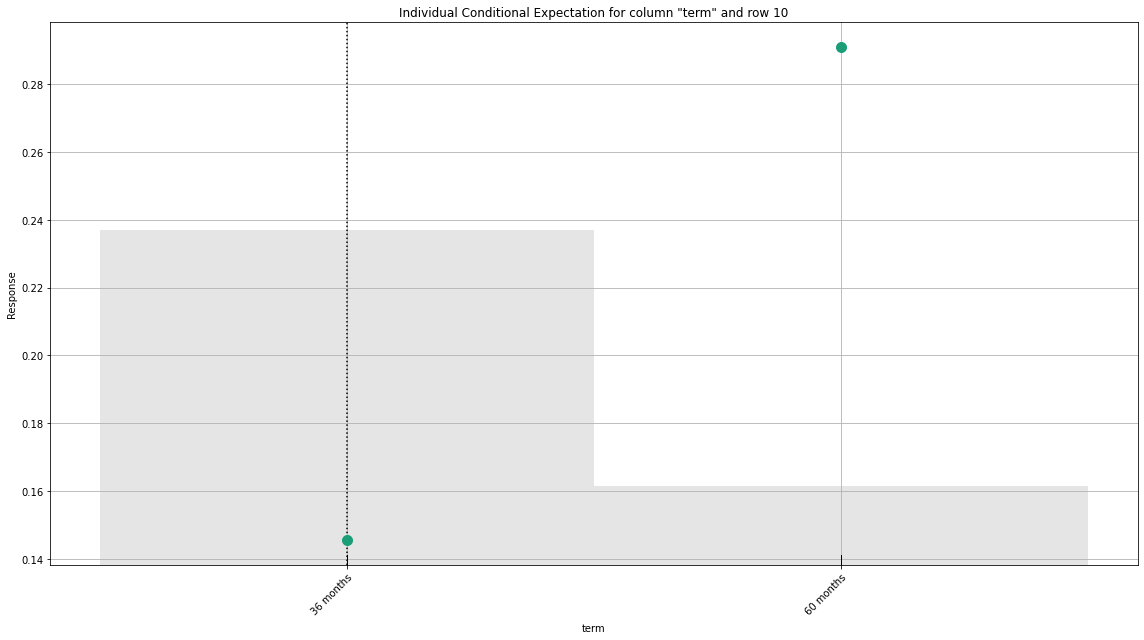

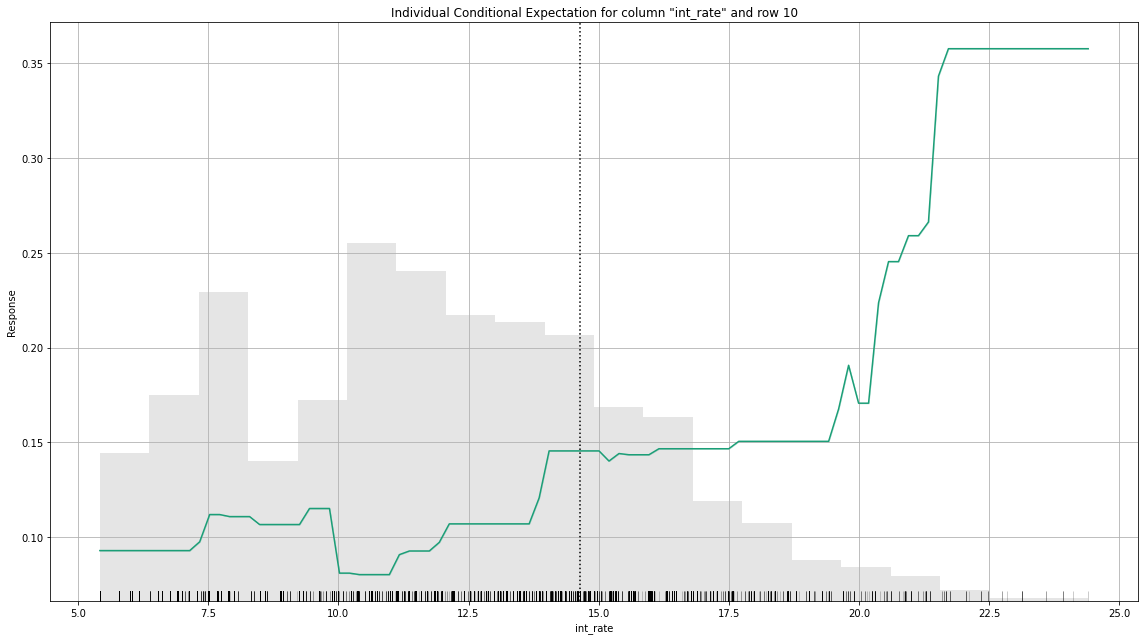

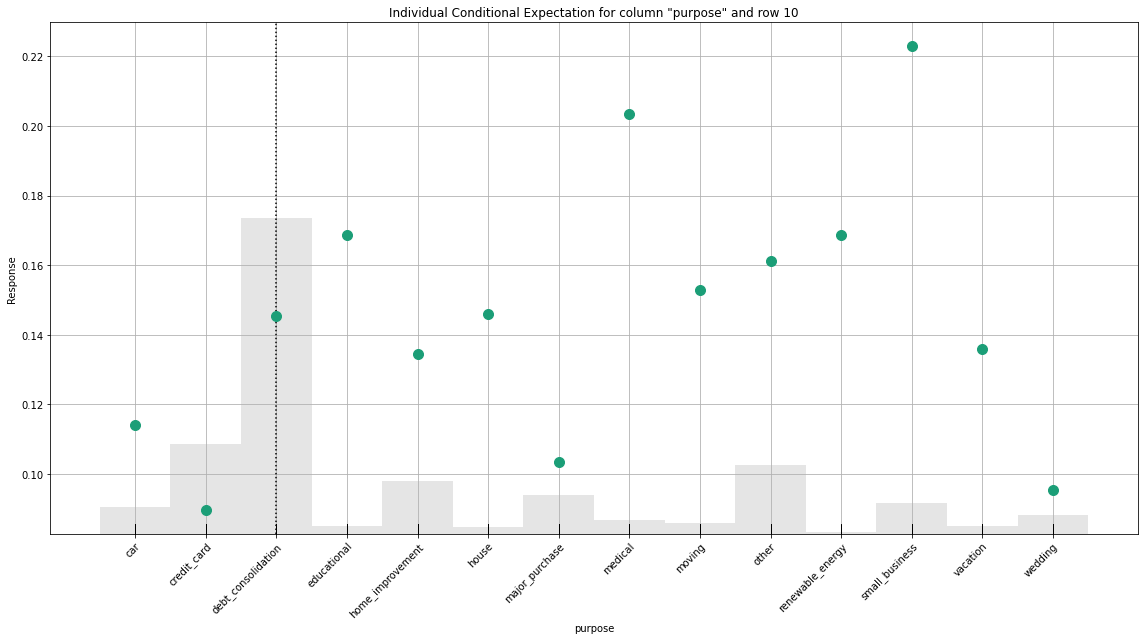

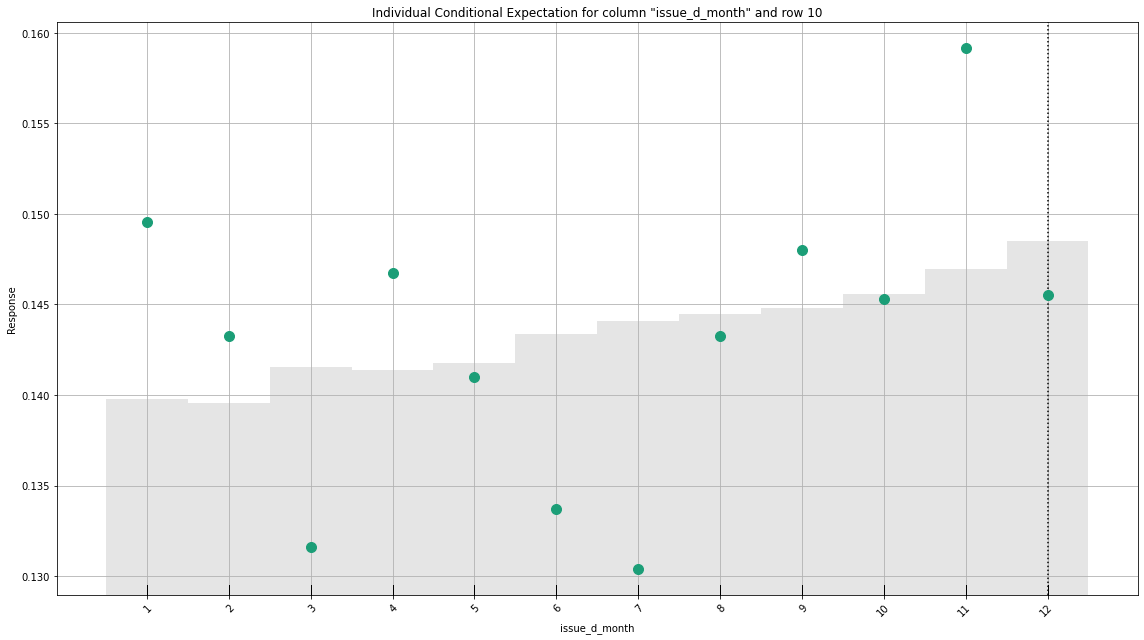

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

In [8]:
gbm.explain_row(test, row_index=10)

# Global Explanations for Multiple Models
## Recreate the AutoML model from Chapter 5

In [9]:
from h2o.estimators import H2OTargetEncoderEstimator

encoded_columns = ["purpose", "addr_state"]
train_cv["fold"] = train_cv.kfold_column(n_folds=5, seed=25)

te = H2OTargetEncoderEstimator(
    data_leakage_handling = "k_fold",
    fold_column = "fold",
    noise = 0.05,
    blending = True,
    inflection_point = 10,
    smoothing = 20
)

In [10]:
te.train(x = encoded_columns,
         y = response,
         training_frame = train_cv)

targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%
Model Details
H2OTargetEncoderEstimator :  TargetEncoder
Model Key:  TargetEncoder_model_python_1656308802578_104


Target Encoder model summary: Summary for target encoder model


,original_names,encoded_column_names
0,purpose,purpose_te
1,addr_state,addr_state_te


In [11]:
train_te = te.transform(frame = train_cv)
test_te = te.transform(frame = test_cv, noise = 0.0)

predictors.extend(["addr_state_te", "purpose_te"])
drop = ["addr_state", "purpose"]
predictors = [x for x in predictors if x not in drop]
transformed = predictors.copy()

train = train_te
test = test_te

In [12]:
from h2o.automl import H2OAutoML
check = H2OAutoML(max_models = 10,
                  max_runtime_secs_per_model = 60,
                  exclude_algos = ['DeepLearning'],
                  seed = 25)

check.train(x = transformed, 
            y = response, 
            training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220626_224806

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09350953909211718
RMSE: 0.30579329471412087
LogLoss: 0.30986276160305304
Null degrees of freedom: 10078
Residual degrees of freedom: 10068
Null deviance: 8742.080439644425
Residual deviance: 6246.213548394343
AIC: 6268.213548394343
AUC: 0.8984371968448281
AUCPR: 0.6791330564329885
Gini: 0.7968743936896563

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2642653666716376: 


,,0,1,Error,Rate
0,0,7883.0,620.0,0.0729,(620.0/8503.0)
1,1,624.0,952.0,0.3959,(624.0/1576.0)
2,Total,8507.0,1572.0,0.1234,(1244.0/10079.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.264265,0.604828,162.0
1,max f2,0.157942,0.701667,246.0
2,max f0point5,0.352566,0.657248,112.0
3,max accuracy,0.352566,0.888977,112.0
4,max precision,0.902684,1.000000,0.0
5,max recall,0.052357,1.000000,355.0
6,max specificity,0.902684,1.000000,0.0
7,max absolute_mcc,0.272049,0.533573,158.0
8,max min_per_class_accuracy,0.183485,0.802305,222.0
9,max mean_per_class_accuracy,0.157942,0.809947,246.0



Gains/Lift Table: Avg response rate: 15.64 %, avg score: 15.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010021,0.568296,6.205345,6.205345,0.970297,0.626614,0.970297,0.626614,0.062183,0.062183,520.534503,520.534503,0.061830
1,2,0.020042,0.509479,6.205345,6.205345,0.970297,0.537945,0.970297,0.582279,0.062183,0.124365,520.534503,520.534503,0.123660
2,3,0.030063,0.471650,6.015385,6.142025,0.940594,0.490826,0.960396,0.551795,0.060279,0.184645,501.538549,514.202518,0.183233
3,4,0.040083,0.446197,5.002268,5.857086,0.782178,0.458152,0.915842,0.528384,0.050127,0.234772,400.226793,485.708587,0.230773
4,5,0.050005,0.415722,4.668572,5.621270,0.730000,0.432136,0.878968,0.509287,0.046320,0.281091,366.857234,462.126969,0.273917
5,6,0.100010,0.323129,3.514880,4.568075,0.549603,0.365076,0.714286,0.437182,0.175761,0.456853,251.487969,356.807469,0.422982
6,7,0.150015,0.269839,2.677399,3.937850,0.418651,0.293523,0.615741,0.389295,0.133883,0.590736,167.739933,293.784957,0.522407
7,8,0.200020,0.230687,1.674961,3.372127,0.261905,0.247966,0.527282,0.353963,0.083756,0.674492,67.496072,237.212736,0.562414
8,9,0.300030,0.180417,1.414834,2.719696,0.221230,0.202096,0.425265,0.303341,0.141497,0.815990,41.483424,171.969632,0.611591
9,10,0.400040,0.149305,0.983405,2.285623,0.153770,0.164456,0.357391,0.268620,0.098350,0.914340,-1.659503,128.562348,0.609624




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1222094408672572
RMSE: 0.3495846690964253
LogLoss: 0.39577411927718953
Null degrees of freedom: 31285
Residual degrees of freedom: 31275
Null deviance: 27631.81948270279
Residual deviance: 24764.378191412303
AIC: 24786.378191412303
AUC: 0.7272869600885257
AUCPR: 0.33979076543259285
Gini: 0.45457392017705134

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19865444624473252: 


,,0,1,Error,Rate
0,0,20315.0,5929.0,0.2259,(5929.0/26244.0)
1,1,2290.0,2752.0,0.4542,(2290.0/5042.0)
2,Total,22605.0,8681.0,0.2627,(8219.0/31286.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.198654,0.401078,210.0
1,max f2,0.113078,0.545311,291.0
2,max f0point5,0.282714,0.370635,147.0
3,max accuracy,0.512144,0.840536,40.0
4,max precision,0.774669,1.000000,0.0
5,max recall,0.009081,1.000000,397.0
6,max specificity,0.774669,1.000000,0.0
7,max absolute_mcc,0.208150,0.262923,202.0
8,max min_per_class_accuracy,0.161337,0.664571,243.0
9,max mean_per_class_accuracy,0.148095,0.665715,255.0



Gains/Lift Table: Avg response rate: 16.12 %, avg score: 16.12 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.523106,3.608064,3.608064,0.581470,0.576710,0.581470,0.576710,0.036097,0.036097,260.806415,260.806415,0.031105
1,2,0.020009,0.472254,2.953855,3.280959,0.476038,0.495960,0.528754,0.536335,0.029552,0.065649,195.385471,228.095943,0.054408
2,3,0.030013,0.440930,2.834908,3.132275,0.456869,0.456518,0.504792,0.509729,0.028362,0.094010,183.490754,213.227547,0.076292
3,4,0.040018,0.412453,2.478066,2.968723,0.399361,0.425736,0.478435,0.488731,0.024792,0.118802,147.806603,196.872311,0.093920
4,5,0.050022,0.391445,2.616838,2.898346,0.421725,0.401652,0.467093,0.471315,0.026180,0.144982,161.683773,189.834603,0.113203
5,6,0.100013,0.321454,2.138451,2.518520,0.344629,0.352698,0.405880,0.412026,0.106902,0.251884,113.845057,151.851973,0.181049
6,7,0.150003,0.272245,1.924209,2.320458,0.310102,0.295343,0.373961,0.373140,0.096192,0.348076,92.420877,132.045829,0.236127
7,8,0.200026,0.236367,1.708874,2.167513,0.275399,0.253568,0.349313,0.343237,0.085482,0.433558,70.887434,116.751344,0.278399
8,9,0.300006,0.189294,1.358848,1.898016,0.218990,0.210751,0.305881,0.299084,0.135859,0.569417,35.884846,89.801588,0.321170
9,10,0.400019,0.157137,1.072850,1.691708,0.172899,0.172521,0.272633,0.267441,0.107299,0.676716,7.284974,69.170786,0.329855




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.741707,0.014909,0.757232,0.752629,0.725623,0.726124,0.746924
1,auc,0.727494,0.009358,0.733552,0.735271,0.713879,0.721565,0.733204
2,err,0.258294,0.014909,0.242768,0.247371,0.274377,0.273876,0.253076
3,err_count,1616.600000,102.889750,1519.000000,1529.000000,1739.000000,1712.000000,1584.000000
4,f0point5,0.350151,0.017508,0.365165,0.364194,0.325666,0.338028,0.357701
5,f1,0.403441,0.015571,0.416891,0.416635,0.382238,0.392045,0.409396
6,f2,0.476034,0.010990,0.485689,0.486718,0.462597,0.466610,0.478556
7,lift_top_group,3.559900,0.547844,3.194129,3.503287,3.367063,4.514467,3.220554
8,logloss,0.395755,0.004529,0.390593,0.392977,0.396267,0.402619,0.396317
9,max_per_class_error,0.458884,0.005700,0.454271,0.451807,0.462000,0.465634,0.460707



See the whole table with table.as_data_frame()


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20220626_224806,0.727287,0.395774,0.339791,0.340052,0.349585,0.122209,4582,0.014845,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_224806,0.727194,0.395814,0.340289,0.342703,0.349566,0.122197,4536,0.009278,StackedEnsemble
GBM_2_AutoML_1_20220626_224806,0.721371,0.398799,0.331962,0.342702,0.350927,0.12315,410,0.002303,GBM
GBM_3_AutoML_1_20220626_224806,0.71898,0.400586,0.323273,0.34103,0.351954,0.123871,468,0.002337,GBM
XGBoost_3_AutoML_1_20220626_224806,0.717686,0.401164,0.325658,0.34377,0.352146,0.124007,2119,0.001013,XGBoost
GBM_1_AutoML_1_20220626_224806,0.717628,0.399779,0.330576,0.343223,0.351145,0.123303,700,0.002521,GBM
GLM_1_AutoML_1_20220626_224806,0.715372,0.401223,0.329676,0.348048,0.351366,0.123458,418,0.00078,GLM
GBM_4_AutoML_1_20220626_224806,0.71148,0.404349,0.311935,0.347472,0.353771,0.125154,440,0.001994,GBM
XRT_1_AutoML_1_20220626_224806,0.705638,0.406532,0.3155,0.357294,0.353844,0.125206,2249,0.004336,DRF
DRF_1_AutoML_1_20220626_224806,0.705345,0.414094,0.310919,0.345657,0.354596,0.125739,2046,0.003567,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20220626_224806


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1935794612102654: 


,,0,1,Error,Rate
0,0,5046.0,1486.0,0.2275,(1486.0/6532.0)
1,1,550.0,612.0,0.4733,(550.0/1162.0)
2,Total,5596.0,2098.0,0.2646,(2036.0/7694.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

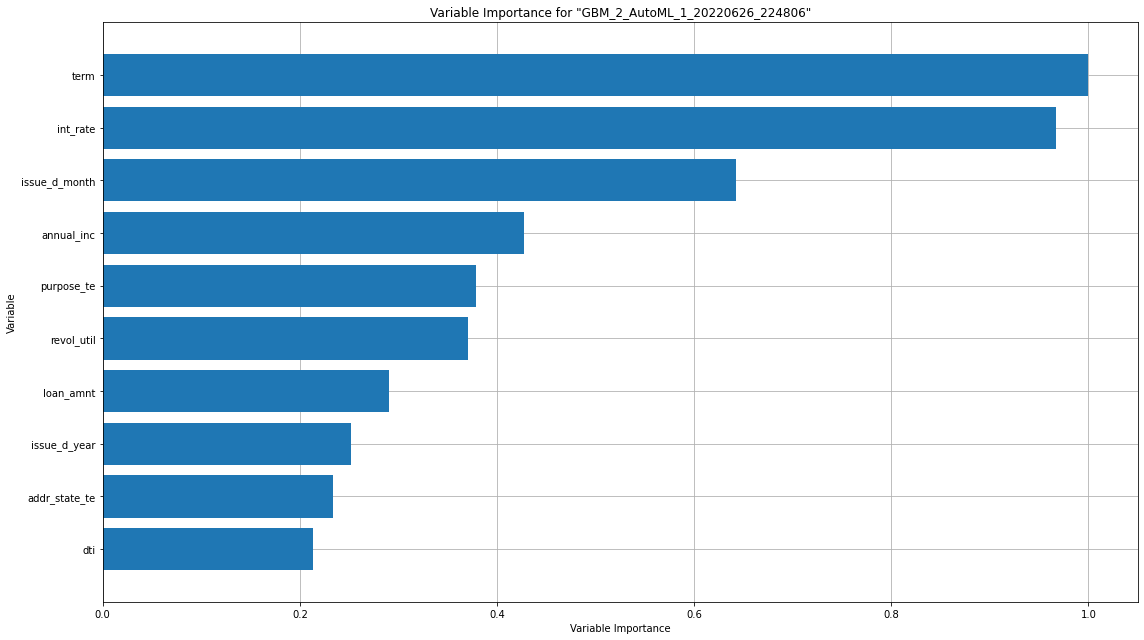

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

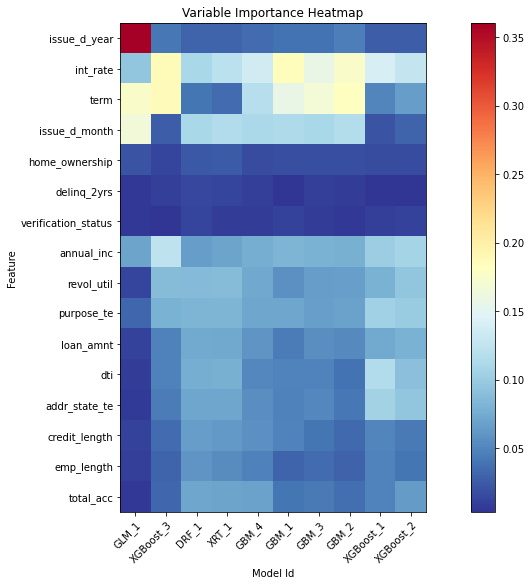

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

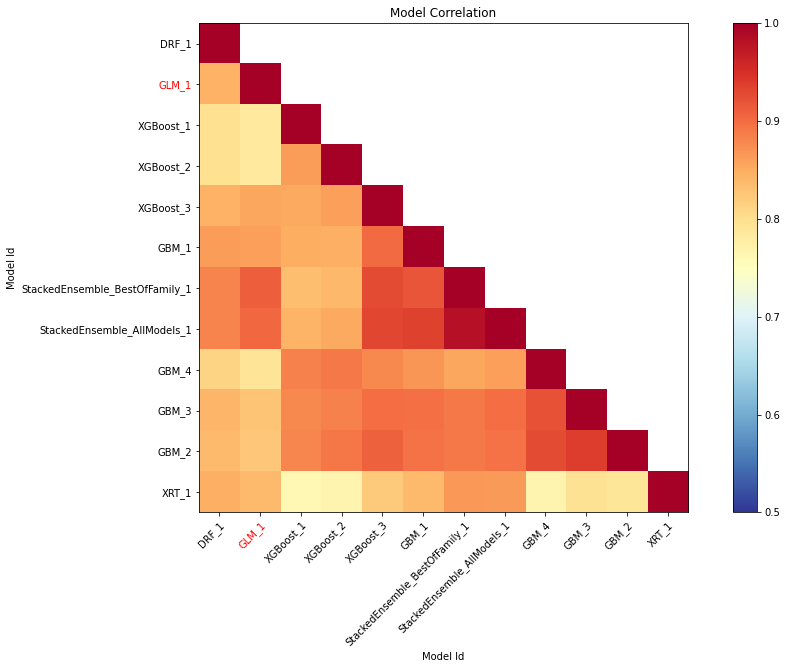

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

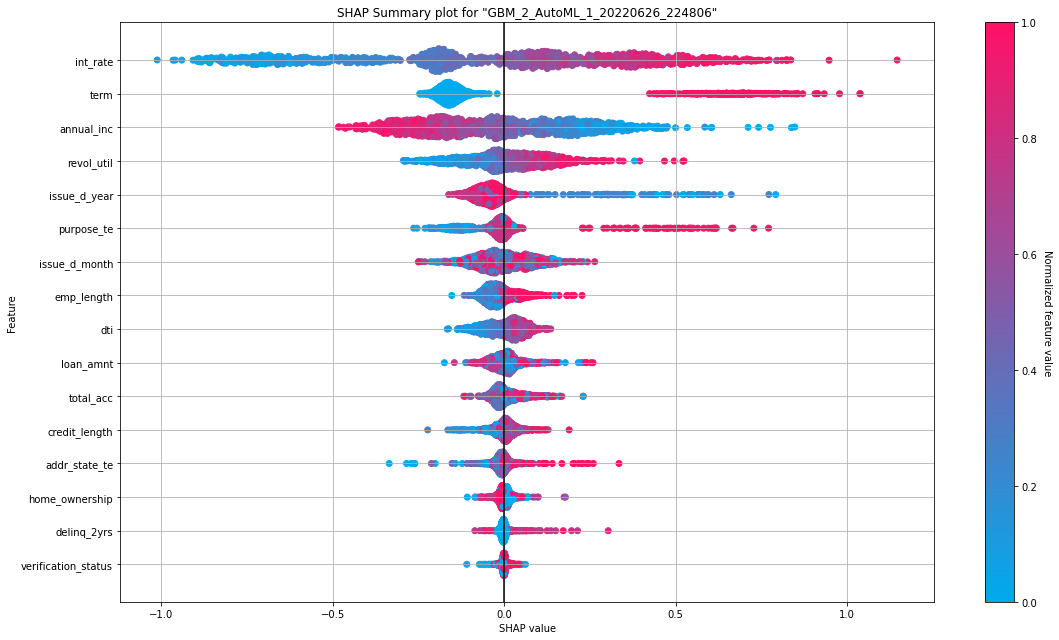

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

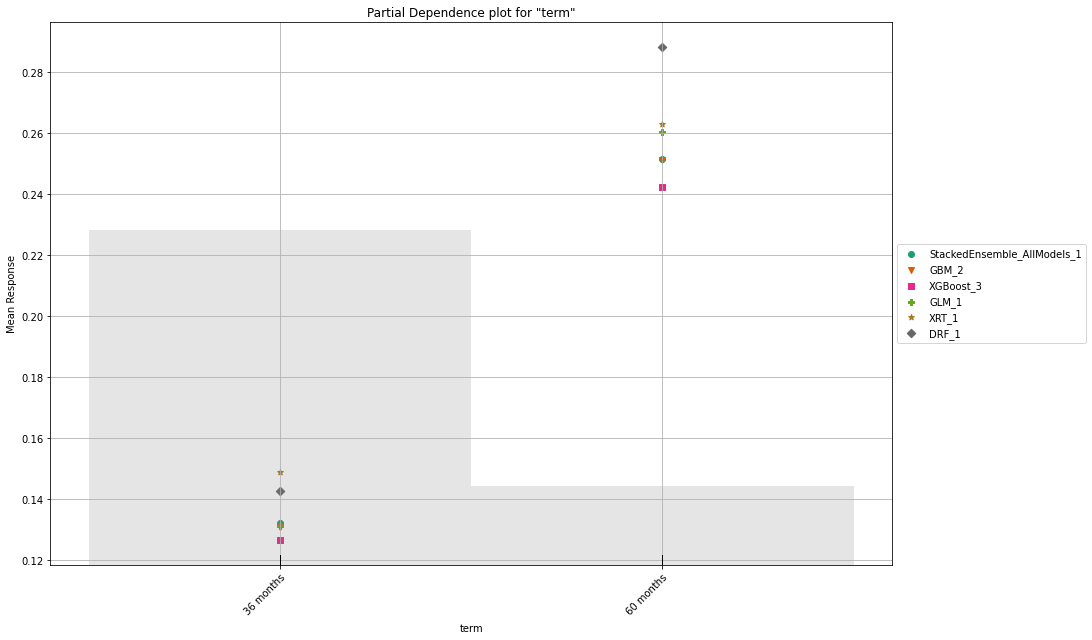

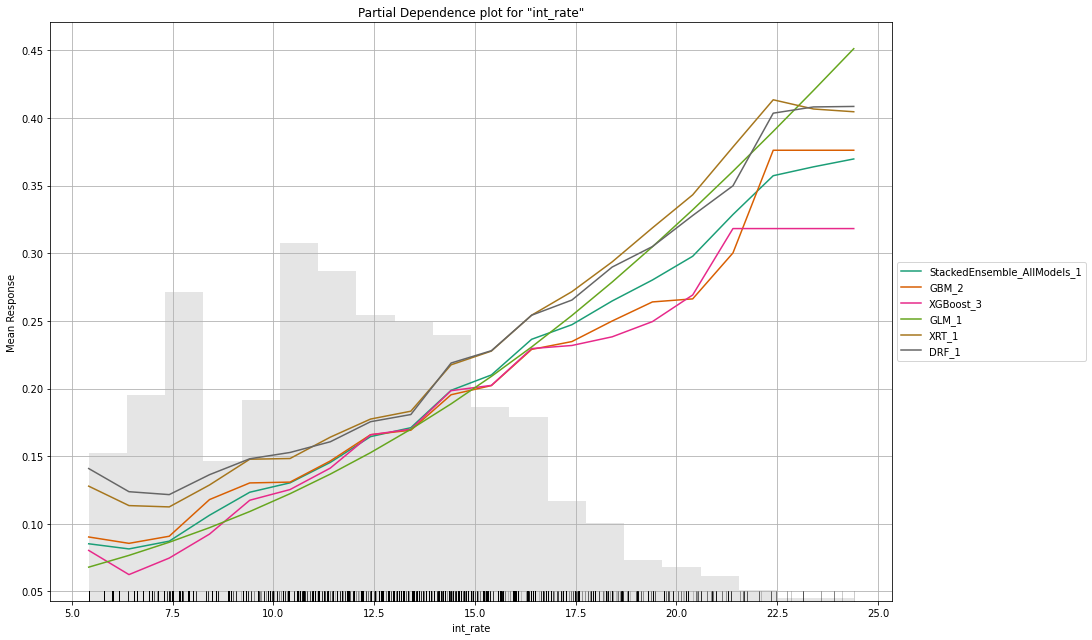

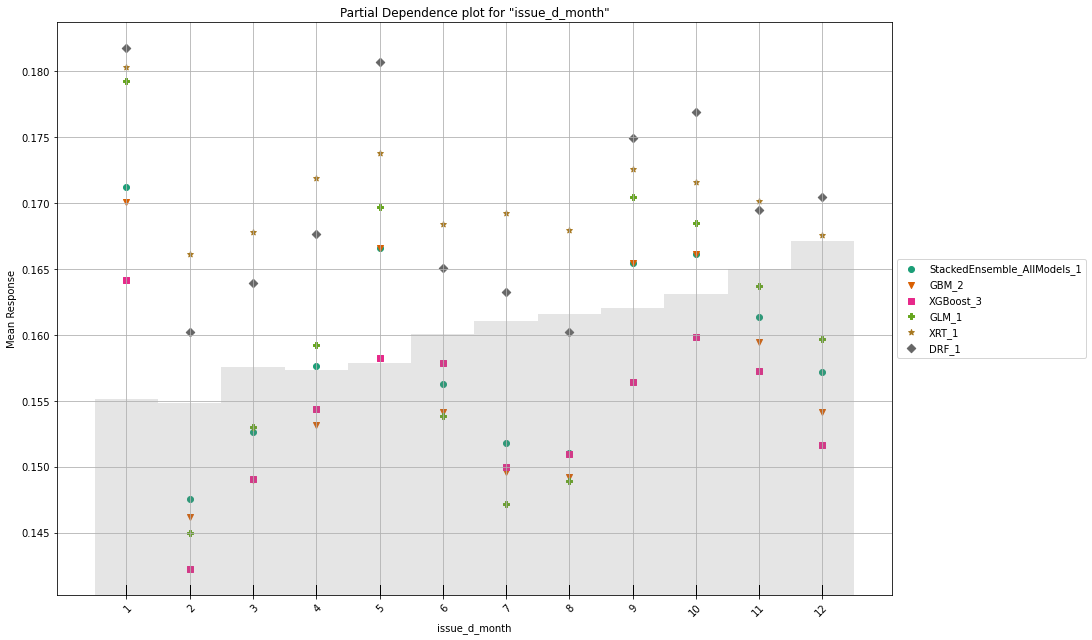

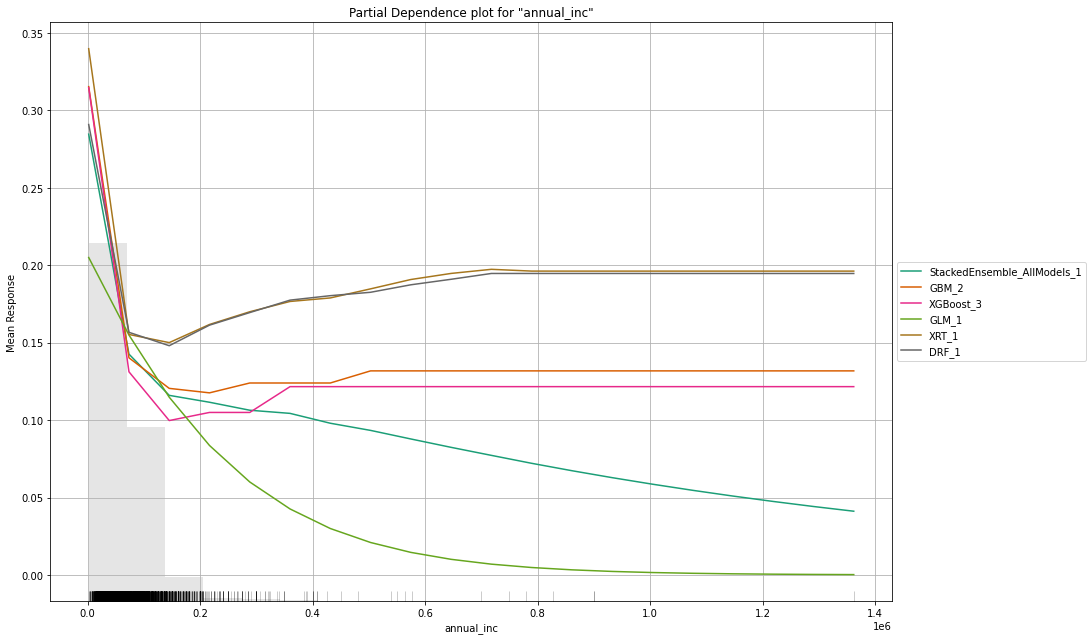

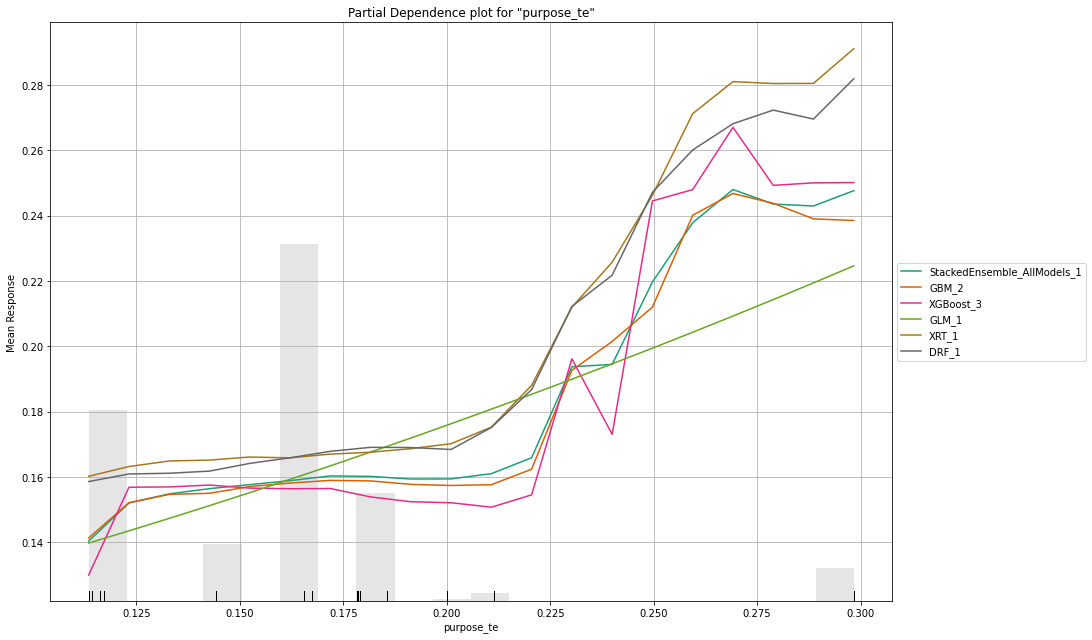

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20220626_224806,0.727287,0.395774,0.339791,0.340052,0.349585,0.122209,4582,0.014845,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_224806,0.727194,0.395814,0.340289,0.342703,0.349566,0.122197,4536,0.009278,StackedEnsemble
GBM_2_AutoML_1_20220626_224806,0.721371,0.398799,0.331962,0.342702,0.350927,0.12315,410,0.002303,GBM
GBM_3_AutoML_1_20220626_224806,0.71898,0.400586,0.323273,0.34103,0.351954,0.123871,468,0.002337,GBM
XGBoost_3_AutoML_1_20220626_224806,0.717686,0.401164,0.325658,0.34377,0.352146,0.124007,2119,0.001013,XGBoost
GBM_1_AutoML_1_20220626_224806,0.717628,0.399779,0.330576,0.343223,0.351145,0.123303,700,0.002521,GBM
GLM_1_AutoML_1_20220626_224806,0.715372,0.401223,0.329676,0.348048,0.351366,0.123458,418,0.00078,GLM
GBM_4_AutoML_1_20220626_224806,0.71148,0.404349,0.311935,0.347472,0.353771,0.125154,440,0.001994,GBM
XRT_1_AutoML_1_20220626_224806,0.705638,0.406532,0.3155,0.357294,0.353844,0.125206,2249,0.004336,DRF
DRF_1_AutoML_1_20220626_224806,0.705345,0.414094,0.310919,0.345657,0.354596,0.125739,2046,0.003567,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20220626_224806


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1935794612102654: 


,,0,1,Error,Rate
0,0,5046.0,1486.0,0.2275,(1486.0/6532.0)
1,1,550.0,612.0,0.4733,(550.0/1162.0)
2,Total,5596.0,2098.0,0.2646,(2036.0/7694.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [13]:
check.explain(test)

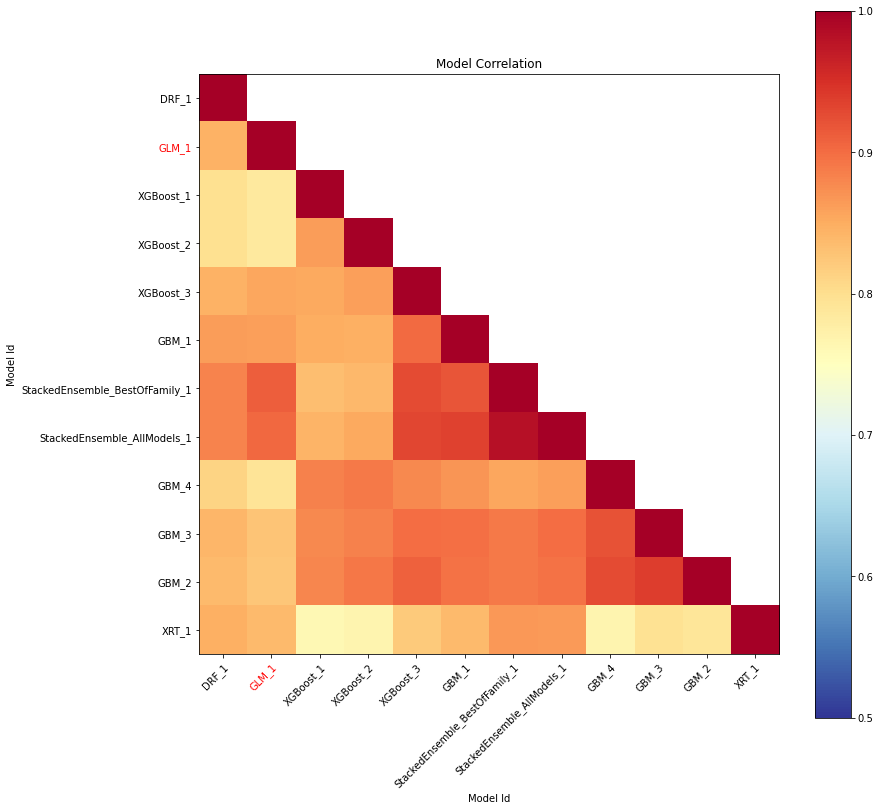

In [14]:
check.model_correlation_heatmap(test)

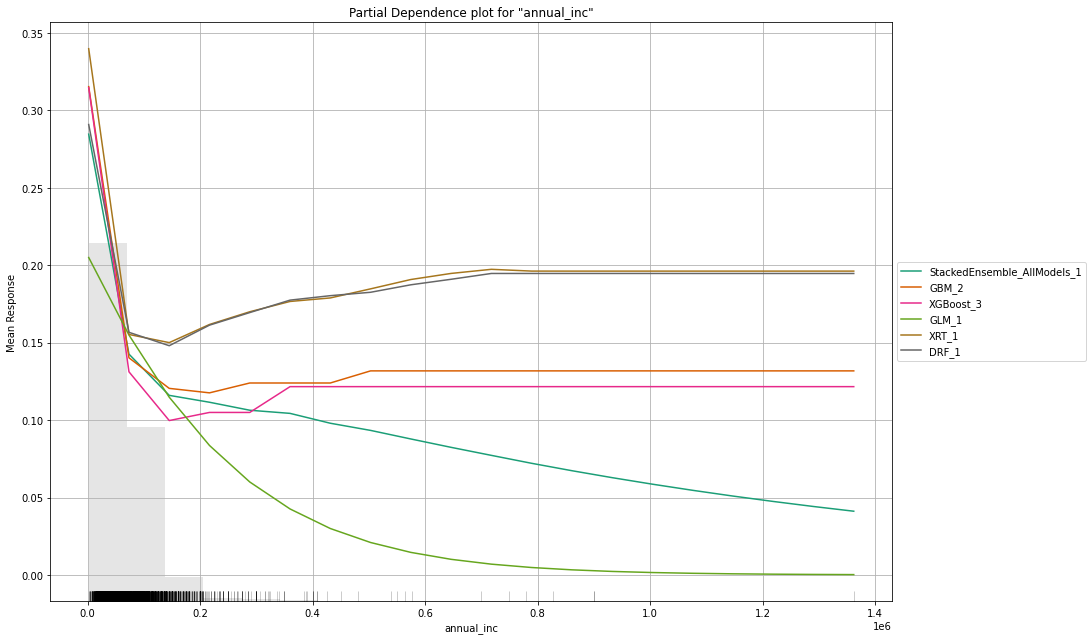

In [15]:
check.pd_multi_plot(test, column='annual_inc')

In [16]:
h2o.cluster().shutdown(prompt = True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_aef7 closed.
